## CIFAR10 data load & normalize

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
           'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz
170500096it [04:36, 1914065.61it/s]                               Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


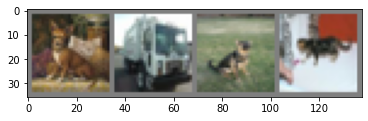

  dog truck   dog   cat


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
# train image 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
images[0].shape

torch.Size([3, 32, 32])

## CNN define

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

## Loss and Optimizer

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
net(images)

tensor([[-1.9227, -2.2350,  1.6562,  0.5579,  2.2924,  1.3353,  0.9017,  1.3882,
         -2.8047, -2.0168],
        [ 1.0535,  1.9649, -0.8622, -1.0049, -1.7303, -1.8336, -0.0426, -1.7151,
          2.4162,  4.4681],
        [-0.1538, -1.9946,  2.0867, -0.1053,  1.9901, -0.1806,  1.4846, -0.3807,
         -1.1709, -1.2708],
        [ 1.4595, -2.9960,  0.8763,  2.1211,  0.2778,  3.0575, -1.0314, -0.8913,
         -0.9342, -3.4934]], grad_fn=<AddmmBackward>)

In [18]:
net(images).argmax(axis=1)

tensor([4, 9, 2, 5])

In [17]:
labels

tensor([3, 9, 7, 2])

## Train NN

In [13]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 inputs 받아오기
        inputs, labels = data
        
        optimizer.zero_grad() # gradient 매개변수 0 초기화
        
        # forward, backward, optim
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished training')

[1,  2000] loss: 2.231
[1,  4000] loss: 1.920
[1,  6000] loss: 1.722
[1,  8000] loss: 1.619
[1, 10000] loss: 1.546
[1, 12000] loss: 1.461
[2,  2000] loss: 1.399
[2,  4000] loss: 1.382
[2,  6000] loss: 1.355
[2,  8000] loss: 1.347
[2, 10000] loss: 1.342
[2, 12000] loss: 1.312
Finished training


In [19]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Test with test data

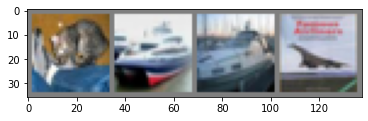

GroundTruth:    cat  ship  ship plane


In [20]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [21]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [22]:
outputs = net(images)

In [23]:
_, predicted = torch.max(outputs, 1)

print("predicted: ", ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

predicted:   frog  ship  ship plane


In [24]:
# test with entire dataset

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print("Acc of the net: %d %%" % (100 * correct / total))

Acc of the net: 53 %


In [25]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 54 %
Accuracy of   car : 65 %
Accuracy of  bird : 36 %
Accuracy of   cat : 12 %
Accuracy of  deer : 40 %
Accuracy of   dog : 52 %
Accuracy of  frog : 70 %
Accuracy of horse : 68 %
Accuracy of  ship : 77 %
Accuracy of truck : 59 %


## Train on GPU

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [27]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [28]:
inputs, labels = data[0].to(device), data[1].to(device)